In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os
from PIL import Image
import array as arr
from sklearn.preprocessing import MinMaxScaler
import skimage.feature
from skimage.feature import greycomatrix
from skimage.filters import rank, try_all_threshold
from skimage.morphology import disk
import skimage.measure 
from glrlm import GLRLM
from sklearn.cluster import KMeans, MeanShift, DBSCAN
import umap

# Read Patient Dataset

In [2]:
HomeLi = [pd.read_csv("HrData1.csv"),
          pd.read_csv("HrData2.csv"),
          pd.read_csv("HrData3.csv"),
          pd.read_csv("HrData4.csv"),
          pd.read_csv("HrData5.csv"),
          pd.read_csv("HrData6.csv"),
          pd.read_csv("HrData7.csv")]
for i in range(len(HomeLi)):
    HomeLi[i].drop(['total','Unnamed: 0'],axis=1,inplace=True)

# Seasonal Min-Max Normalisation

In [3]:
summer = []
autumn = []
winter = []
spring = []

for i in range(6,7):
    for j in range(0,len(HomeLi[i]),24):
        month = HomeLi[i].iloc[j,0]
        if month[5:7] == '08' or month[5:7] == '06' or month[5:7] == '07':
            summer.append(HomeLi[i][j:j+24])
        if month[5:7] == '09' or month[5:7] == '10' or month[5:7] == '11':
            autumn.append(HomeLi[i][j:j+24])
        if month[5:7] == '12' or month[5:7] == '01' or month[5:7] == '02':
            winter.append(HomeLi[i][j:j+24])
        if month[5:7] == '03' or month[5:7] == '04' or month[5:7] == '05':
            spring.append(HomeLi[i][j:j+24])
            
            
CSummer = pd.DataFrame()
for s in range(0,len(summer)):
    CSummer = CSummer.append(summer[s], ignore_index=True)
CAutumn = pd.DataFrame()
for s in range(0,len(autumn)):
    CAutumn = CAutumn.append(autumn[s], ignore_index=True)
Cwinter = pd.DataFrame()
for s in range(0,len(winter)):
    Cwinter = Cwinter.append(winter[s], ignore_index=True)
Cspring = pd.DataFrame()
for s in range(0,len(spring)):
    Cspring = Cspring.append(spring[s], ignore_index=True)
    

TimeSummer = CSummer.iloc[:,0:2]
TimeAutumn = CAutumn.iloc[:,0:2]
TimeSpring = Cspring.iloc[:,0:2]
TimeWinter = Cwinter.iloc[:,0:2]


CSummer.drop(['date','hour'],axis=1,inplace=True)
CAutumn.drop(['date','hour'],axis=1,inplace=True)
Cwinter.drop(['date','hour'],axis=1,inplace=True)
Cspring.drop(['date','hour'],axis=1,inplace=True)


Smin_value, Smax_value = CSummer.min().min(), CSummer.max().max()
Summerscaled1 = (CSummer - Smin_value) * 1 / (Smax_value - Smin_value)

Amin_value, Amax_value = CAutumn.min().min(), CAutumn.max().max()
Autumnscaled1 = (CAutumn - Amin_value) * 1 / (Amax_value - Amin_value)

Wmin_value, Wmax_value = Cwinter.min().min(), Cwinter.max().max()
Winterscaled1 = (Cwinter - Wmin_value) * 1 / (Wmax_value - Wmin_value)

Spmin_value, Spmax_value = Cspring.min().min(), Cspring.max().max()
Springscaled1 = (Cspring - Spmin_value) * 1 / (Spmax_value - Spmin_value)


summerNew = pd.concat([TimeSummer, Summerscaled1], axis=1)
autumnNew = pd.concat([TimeAutumn, Autumnscaled1], axis=1)
winterNew = pd.concat([TimeWinter, Winterscaled1], axis=1)
springNew = pd.concat([TimeSpring, Springscaled1], axis=1)


Patient = pd.DataFrame()
Patient = Patient.append(summerNew, ignore_index=True)
Patient = Patient.append(autumnNew, ignore_index=True)
Patient = Patient.append(winterNew, ignore_index=True)
Patient = Patient.append(springNew, ignore_index=True)

C:\Users\Anisha Jubitha\AppData\Local\Temp\ipykernel_22340\2646746379.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CSummer = CSummer.append(summer[s], ignore_index=True)
C:\Users\Anisha Jubitha\AppData\Local\Temp\ipykernel_22340\2646746379.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CAutumn = CAutumn.append(autumn[s], ignore_index=True)
C:\Users\Anisha Jubitha\AppData\Local\Temp\ipykernel_22340\2646746379.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Cwinter = Cwinter.append(winter[s], ignore_index=True)
C:\Users\Anisha Jubitha\AppData\Local\Temp\ipykernel_22340\2646746379.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

In [12]:
Amin_value, Amax_value

(0, 24)

# Texture Analysis using Histogram, GLCM & GLRLM

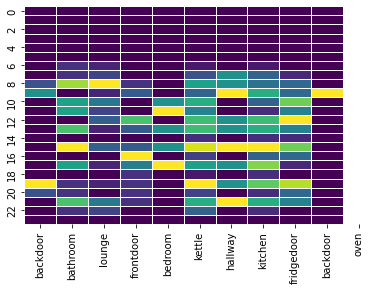

In [93]:
count = 0
dli = []

for i in range(0,1):
    for j in range(0,len(Patient),24):
        df = pd.DataFrame(Patient[j:j+24])
        
        df = pd.pivot_table(Patient[j:j+24],index = 'hour') 
        mms = MinMaxScaler()
        df_norm = mms.fit_transform(df)
        
        normalised_hmap = sb.heatmap(df_norm, linewidths=.5, cmap='viridis', cbar=False, xticklabels=['backdoor', 'bathroom', 'lounge', 'frontdoor', 'bedroom', 'kettle', 'hallway',  'kitchen', 'fridgedoor', 'backdoor', 'oven'])
        
        df_new = df_norm*100
        df_new = df_new.astype(np.int8)
        
        result = skimage.feature.graycomatrix(df_new, [1], [np.pi/2])
        contrast = np.round(skimage.feature.graycoprops(result, 'contrast'),5)
        dissimilarity = np.round(skimage.feature.graycoprops(result, 'dissimilarity'),5)
        homogeneity = np.round(skimage.feature.graycoprops(result, 'homogeneity'),5)
        asm = np.round(skimage.feature.graycoprops(result, 'ASM'),5)
        energy = np.round(skimage.feature.graycoprops(result, 'energy'),5)
        entropy = np.round(skimage.measure.shannon_entropy(result),5)
        
        
        app = GLRLM()
        glrlm = app.get_features(df_new, 8)
        SRE = glrlm.SRE
        LRE = glrlm.LRE
        GLU = glrlm.GLU
        RLU = glrlm.RLU
        RPC = glrlm.RPC
        
        mean = np.mean(df_new)
        var = np.var(df_new)
        maxm = np.max(df_new)
        minm = np.min(df_new)
    
    
        count +=1
        
        dli.append([float(contrast), float(dissimilarity), float(homogeneity), 
                    float(asm), float(energy), float(entropy), mean, var, maxm, minm,
                    SRE, LRE, GLU, RLU, RPC])

In [94]:
Texturedata = pd.DataFrame(dli, columns= ['Contrast', 'Dissimilarity', 'Homogeneity', 'ASM', 'Energy', 'Enrtopy',
                                          'Mean', 'Variance', 'Maximum', 'Minimum', 'SRE',
                                             'LRE', 'GLU', 'RLU', 'RPC',])
Texturedata

,Contrast,Dissimilarity,Homogeneity,ASM,Energy,Enrtopy,Mean,Variance,Maximum,Minimum,SRE,LRE,GLU,RLU,RPC
0,1140.26087,15.21739,0.73507,0.52484,0.72446,0.00873,0.358333,0.704931,3,0,2.718,92.831,237.677,150.010,1.766
1,1141.80000,20.39130,0.47521,0.21781,0.46670,0.01496,0.483333,0.716389,3,0,2.524,34.104,171.140,177.751,2.416
2,1515.47826,23.76522,0.50931,0.21580,0.46455,0.01438,0.545833,0.772899,3,0,2.813,29.550,158.237,234.224,2.615
3,1238.80870,19.94783,0.55301,0.22677,0.47620,0.01367,0.583333,0.876389,3,0,2.738,29.996,158.533,230.816,2.630
4,1070.89565,17.67826,0.61366,0.35002,0.59162,0.01093,0.383333,0.628056,3,0,2.514,57.603,202.090,149.425,2.062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,1395.35652,21.94783,0.52280,0.22457,0.47389,0.01699,0.529167,0.765816,3,0,2.667,33.546,167.611,198.442,2.469
628,1441.72174,24.07826,0.47513,0.17501,0.41834,0.01602,0.666667,0.897222,3,0,2.966,26.260,148.224,278.282,2.798
629,1153.44348,19.20000,0.48475,0.20548,0.45330,0.01661,0.462500,0.681927,3,0,2.658,36.788,173.417,192.628,2.390
630,967.06087,17.61739,0.49926,0.20560,0.45343,0.01705,0.404167,0.557483,3,0,2.590,43.628,181.817,178.002,2.292


# Mean-Shift Clustering 

[[1.23533000e+03 2.06393667e+01 5.02895771e-01 2.13178543e-01
  4.59859143e-01 1.60020571e-02 5.34214286e-01 7.57070238e-01
  3.00000000e+00 0.00000000e+00 2.77833714e+00 3.48674629e+01
  1.64752969e+02 2.23254457e+02 2.53054286e+00]
 [6.68114906e+02 8.07391286e+00 8.77168571e-01 7.53784286e-01
  8.67980000e-01 4.45571429e-03 1.69047619e-01 4.11810516e-01
  3.00000000e+00 0.00000000e+00 1.73871429e+00 2.07433714e+02
  4.16295429e+02 5.03195714e+01 1.02985714e+00]
 [2.06680000e+03 2.78434800e+01 4.83640000e-01 2.12890000e-01
  4.61400000e-01 1.51600000e-02 7.04166667e-01 1.09998264e+00
  3.00000000e+00 0.00000000e+00 3.04500000e+00 2.71540000e+01
  1.47619000e+02 2.98193000e+02 2.80700000e+00]
 [3.71704350e+02 4.33043000e+00 9.43490000e-01 8.90590000e-01
  9.43710000e-01 2.39000000e-03 7.91666667e-02 2.06232639e-01
  3.00000000e+00 0.00000000e+00 1.18100000e+00 3.24162000e+02
  5.68662000e+02 3.38820000e+01 7.76000000e-01]]
Estimated clusters: 4


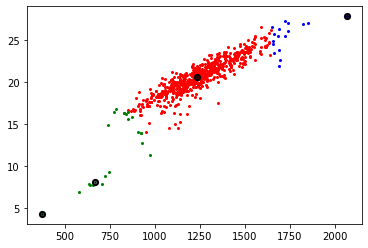

In [97]:
x = Texturedata.iloc[:, :].values
ms = MeanShift()
st = ms.fit(x)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
colors = 10*['r.','g.','b.','c.','k.','y.','m.']
for i in range(len(x)):
    plt.plot(x[i][0], x[i][1], colors[labels[i]], markersize = 4)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
    marker=".",color='k', s=20, linewidths = 5, zorder=10)
plt.show()

In [98]:
ms.labels_

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Cluster count

In [99]:
count = 0
highcount = 0
for i in range(len(ms.labels_)):
    if ms.labels_[i] == 0:
        count +=1
    if ms.labels_[i] > 0:
        highcount +=1
        
count, highcount

(593, 39)